In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import os, sys, getpass
user = getpass.getuser()
sys.path.append(f'/home/{user}/codes/hpe_library/')
from lib_import import *
from my_utils import *
os.chdir('/home/hrai/codes/MotionBERT')

In [2]:
load_folder = '/home/hrai/codes/MotionBERT/data/motion3d/fit3d_gt_pkl'
save_folder = '/home/hrai/codes/MotionBERT/data/motion3d/fit3d_gt_pkl_canonical_3d_same_z'
if not os.path.exists(save_folder): os.makedirs(save_folder)

In [3]:
overwrite = True
for item in tqdm(glob(load_folder + '/*.pkl')):
    save_path = item.replace('fit3d_gt_pkl', 'fit3d_gt_pkl_canonical_3d_same_z')
    if os.path.exists(save_path) and not overwrite: 
        print('already exists', save_path)
        continue
    data = readpkl(item)
    #print(data.keys())
    new_data = {}
    new_data['joint_2d_from_canonical_3d'] = []
    new_data['joint3d_image_from_canonical_3d'] = []
    new_data['world_3d_from_canonical_3d'] = []
    new_data['cam_3d_from_canonical_3d'] = []
    
    cam_param = data['cam_param'][0].reshape(1)[0].copy()
    int_mat = cam_param['intrinsic']
    ext_mat = cam_param['extrinsic']
    cam_proj = int_mat @ ext_mat
    R = ext_mat[:3, :3]
    t = ext_mat[:3, 3]
    C = T_to_C(R, t)
    num_frames = len(data['world_3d'])
    world_3d = np.array(data['world_3d']).copy() # (F, J, 3)
    cam_3d = np.array(data['cam_3d']).copy()/1000 # (F, J, 3)
    world_3d_from_canonical_3d = get_canonical_3d_same_z(world_3d, cam_3d, C, R)

    fx, fy, cx, cy = int_mat[0, 0], int_mat[1, 1], int_mat[0, 2], int_mat[1, 2]
    for frame_num in range(num_frames):
        # world to camera
        pos = world_3d_from_canonical_3d[frame_num].copy()
        cam_3d_from_canonical_3d = World2CameraCoordinate(pos, cam_param['extrinsic']) * 1000 # World coordinate -> Camera coordinate
        cam_3d_from_canonical_3d_hat = get_rootrel_pose(cam_3d)
        
        # camera to image
        box = infer_box(cam_3d_from_canonical_3d, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
        img_2d_from_canonical_3d, img_3d_from_canonical_3d = camera_to_image_frame(cam_3d_from_canonical_3d, box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
        img_3d_from_canonical_3d_hat = get_rootrel_pose(img_2d_from_canonical_3d) # (17, 3) # root-relative pose  
        
        # 2.5d factor
        #pred_lambda, losses = optimize_scaling_factor(img_3d_hat, cam_3d_hat) # x,y,z 사용
        
        # joint 2.5d image
        #img_25d = img_3d * pred_lambda
    
        # store
        new_data['joint_2d_from_canonical_3d'].append(np.array(img_2d_from_canonical_3d).copy())
        new_data['joint3d_image_from_canonical_3d'].append(np.array(img_3d_from_canonical_3d).copy())
        new_data['cam_3d_from_canonical_3d'].append(np.array(cam_3d_from_canonical_3d).copy())
    
    new_data['joint_2d'] = data['joint_2d']#.copy()
    new_data['confidence'] = data['confidence']#.copy()
    new_data['camera_name'] = data['camera_name']#.copy()
    new_data['action'] = data['action']#.copy()
    new_data['source'] = data['source']#.copy()
    new_data['frame'] = data['frame']#.copy()
    new_data['world_3d'] = data['world_3d']#.copy()
    new_data['world_3d_from_canonical_3d'] = list(world_3d_from_canonical_3d)
    new_data['cam_3d'] = data['cam_3d']#.copy()
    new_data['cam_param'] = data['cam_param']#.copy()
    savepkl(new_data, save_path)
    #break

  0%|          | 0/1504 [00:00<?, ?it/s]

100%|██████████| 1504/1504 [11:00<00:00,  2.28it/s]


In [11]:
new_data.keys() - data.keys()

{'2.5d_factor', 'joint3d_image', 'joints_2.5d_image'}

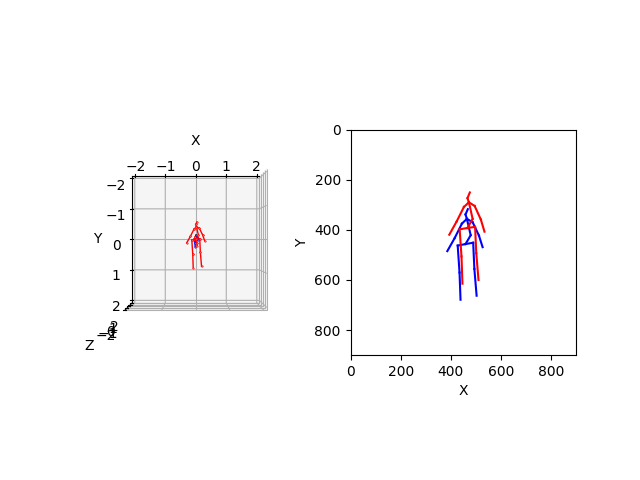

In [9]:
%matplotlib widget
fig = plt.figure(0)
fig.clear()
ax = axes_3d(fig, loc=121, view=(-90,-90))
draw_3d_pose(ax, img_3d_hat/1000)
draw_3d_pose(ax, cam_3d_hat/1000, color='r')
ax2 = axes_2d(fig, loc=122, W=900, H=900)
draw_2d_pose(ax2, new_data['joint_2d_from_canonical_3d'][frame_num], color='b')
draw_2d_pose(ax2, new_data['joint_2d'][frame_num], color='r')
plt.show()